In [1]:
!pip install mxnet --pre --user

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Summary

This notebooks shows an example of MxNet Gluon.

In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon

In [3]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

Let's generate some fake data that conforms with a linear model

In [4]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    """ :param X: 2 dimensional array"""
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

Wrap the data in a data iterator

In [5]:
# (1) Obtain data iterator
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

Define the model. In this case the odel is a single layer with one neuron, no activation function, and one output. That is all, and it is good enough to get started:

In [6]:
# (2) Define networks
# Shape of inputs is inferred once we make a forward pass
net = gluon.nn.Dense(1)

Correct parameter initialization is very important to produce a good neural network. Let's see how to do it using Gluon. Here we initialize the parameters with values drawn from a normal distribution with average 0 and standard deviation 1:

In [7]:
# (3) Initialize parameters
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

Let's now define the loss

In [8]:
# (4) Define loss
square_loss = gluon.loss.L2Loss()

And finally let's define our optimizer

In [9]:
# (5) Define the optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

In [19]:
# Turn the train loop into a reusable function
def train(epochs, batch_size, train_data, ctx, network, loss_func, optimizer):
    loss_sequence = []
    num_batches = num_examples / batch_size
    for e in range(epochs):
        cumulative_loss = 0
        # inner loop
        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                # Forward pass
                output = network(data)
                # Calculate loss
                loss = loss_func(output, label)
            # Calculate gradients
            loss.backward()
            # Execute optimizer
            optimizer.step(batch_size, ignore_stale_grad=True)
            cumulative_loss += nd.mean(loss).asscalar()
        print("Epoch %s, loss: %s" % (e, cumulative_loss / batch_size))
        loss_sequence.append(cumulative_loss)
    return loss_sequence

Finally, let's actually learn through a number of epochs

In [11]:
epochs = 5

loss_sequence = train(epochs, batch_size, train_data, model_ctx, net, square_loss, trainer)

Epoch 0, loss: 7911.003071736544
Epoch 1, loss: 4790.360435131006
Epoch 2, loss: 2900.772010792047
Epoch 3, loss: 1756.5816461313516
Epoch 4, loss: 1063.7385703288019


Let's print the loss over time:

Text(0,0.5,'average loss')

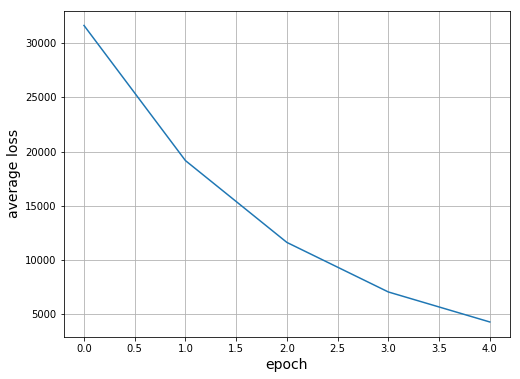

In [12]:

# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Finally we can also print out the parameters of the final network

In [13]:
for param in net.collect_params().values():
    print(param.name, param.data())

dense0_weight 
[[ 1.3446947 -2.5351818]]
<NDArray 1x2 @cpu(0)>
dense0_bias 
[3.0017426]
<NDArray 1 @cpu(0)>


## Serialization

Lets try to serialize and load the structure of the network and its weights:

In [14]:
import os, time
# Generatel model filename
model_file = os.path.join("/", "tmp", "model_" + str(time.time()))
# Export model, this actually exports both the network and the parameters
net.export(model_file)

In [15]:
# Load the serialized model
net2 = gluon.SymbolBlock.imports("{}-symbol.json".format(model_file), ["data"], "{}-0000.params".format(model_file))
# Print parameters
for p in net2.collect_params().values():
    print(p.name, p.data())

dense0_weight 
[[ 1.3446947 -2.5351818]]
<NDArray 1x2 @cpu(0)>
dense0_bias 
[3.0017426]
<NDArray 1 @cpu(0)>


In [22]:
# Let's continue training the network we just loaded
trainer2 = gluon.Trainer(net2.collect_params(), 'sgd', {'learning_rate': 0.0001})
train(epochs, batch_size, train_data, model_ctx, net2, square_loss, trainer2)

Epoch 0, loss: 644.1815015515313
Epoch 1, loss: 390.1192895830609
Epoch 2, loss: 236.26608199230395
Epoch 3, loss: 143.096633137553
Epoch 4, loss: 86.67575112712802


[2576.726006206125,
 1560.4771583322436,
 945.0643279692158,
 572.386532550212,
 346.7030045085121]